In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import logging
import scipy.stats as sts
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import os

In [2]:
from arch import arch_model

In [3]:
ini_work_dir = os.getcwd()
os.chdir('..')

In [4]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from antecedent_fitting import fit_antecedent_params
from local_models import calculate_retraining_garch_forecasts

In [5]:
with open('config.json') as file:
    config = json.load(file)

In [30]:
files_folder = config['files_folders']['processed']
research_results_folder = config['files_folders']['research_results']
antecedent_params_folder = config['files_folders']['antecedent_params_sets']
metadata_file_name = 'current_antecedent_fitting_metadata_seasonal.pkl'
logs_folder = config['files_folders']['logs']
summary_table_name = 'summary_table_seas'

In [7]:
logger = logging.getLogger('apf_seas_nb')  # apf == antecedent params fitting

_log_file = f'{logs_folder}/apf_seas_nb.log'
logging.basicConfig(level=logging.DEBUG,
                    filename=_log_file,
                    filemode='w',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S')

# Reading data

In [8]:
with open(f'{antecedent_params_folder}/{metadata_file_name}', 'rb') as file:
    data = pickle.load(file)

In [9]:
train = data['train']
test = data['test']
consequent_metaparams = data['consequent_metaparams']
consequent_params_ini = data['consequent_metaparams']['parameters_ini']
antecedent_params_set = data['antecedent_params_set']
clusterization_method = data['clusterization_method']
local_method = data['local_method']
data_to_cluster_train = data['data_to_cluster_train']
data_to_cluster_test = data['data_to_cluster_test']
cluster_sets_conjunction = data['cluster_sets_conjunction']
n_last_points_to_use_for_clustering = data['n_last_points_to_use_for_clustering']
other_fvm_parameters = data['other_fvm_parameters']

In [10]:
n_cluster_sets = len(data['clusterization_method'])

p = consequent_metaparams['p']
q = consequent_metaparams['q']

n_train = train.shape[0]
n_test = test.shape[0]

# Main input data plot

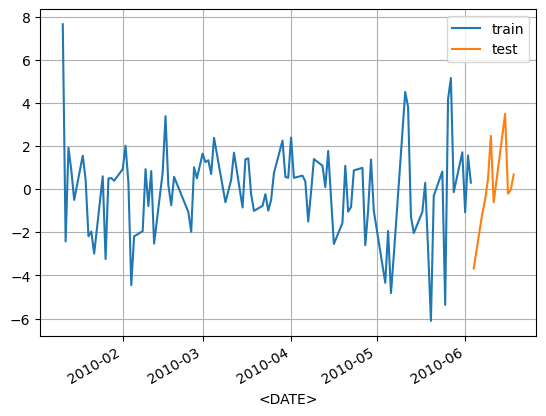

In [11]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

## train & test sizes

In [12]:
print(train.shape[0], test.shape[0])

100 10


# Antecedent params set

In [13]:
# antecedent_params_set = antecedent_params_set[1930:2054]

In [14]:
# for _antecedent_params in antecedent_params_set:
#     _centers = _antecedent_params['centers']
#     _variances = _antecedent_params['variances']
#     _n_clusters = _antecedent_params['n_clusters']
    
#     for i in range(_n_clusters):
#         _range = np.arange(-20, 20, .01)
#         _data = sts.norm(_centers[i], _variances[i] ** .5).pdf(_range)

#         plt.plot(_range, _data, label=f'cluster #{i + 1}')
    
#     plt.title(_antecedent_params)
#     plt.legend()
#     plt.grid()
#     plt.show()

# Fitting

In [15]:
result = None

In [16]:
train.iloc[:5]

<DATE>
2010-01-11    7.668616
2010-01-12   -2.421124
2010-01-13    1.932676
2010-01-14    0.874942
2010-01-15   -0.491052
Name: log return, dtype: float64

In [17]:
data_to_cluster_train

[<DATE>
 2010-01-11    1
 2010-01-12    2
 2010-01-13    3
 2010-01-14    4
 2010-01-15    5
              ..
 2010-05-28    5
 2010-05-31    1
 2010-06-01    2
 2010-06-02    3
 2010-06-03    4
 Name: <DATE>, Length: 100, dtype: int64,
 'train']

In [18]:
data_to_cluster_test

[<DATE>
 2010-06-04    5
 2010-06-07    1
 2010-06-08    2
 2010-06-09    3
 2010-06-10    4
 2010-06-11    5
 2010-06-15    2
 2010-06-16    3
 2010-06-17    4
 2010-06-18    5
 Name: <DATE>, dtype: int64,
 None]

In [22]:
%%time

result = fit_antecedent_params(train,
                               test,
                               consequent_metaparams=consequent_metaparams,
                               consequent_params_ini=consequent_params_ini,
                               antecedent_params_set=antecedent_params_set,
                               clusterization_method=clusterization_method,
                               local_method=local_method,
                               data_to_cluster_train=data_to_cluster_train,
                               data_to_cluster_test=data_to_cluster_test,
                               cluster_sets_conjunction=cluster_sets_conjunction,
                               n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering,
                               n_cluster_sets=n_cluster_sets,
                               other_fvm_parameters=other_fvm_parameters)

KeyboardInterrupt: 

# Adding some info

In [ ]:
result['train'] = train
result['test'] = test
result['antecedent_params_set'] = antecedent_params_set
result['consequent_metaparams'] = consequent_metaparams
result['consequent_params_ini'] = consequent_params_ini
result['clusterization_method'] = clusterization_method
result['local_method'] = local_method
result['data_to_cluster_train'] = data_to_cluster_train
result['data_to_cluster_test'] = data_to_cluster_test

## Vanilla GARCH errors

### No retraining

In [23]:
garch_mean = 'Zero'
garch_dist = 'normal'
garch_vol = 'GARCH'

garch = arch_model(train,
                   mean=garch_mean,
                   vol=garch_vol,
                   p=p,
                   q=q,
                   dist=garch_dist)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 299.2568988057981
Iteration:      2,   Func. Count:     11,   Neg. LLF: 218.16618783247299
Iteration:      3,   Func. Count:     19,   Neg. LLF: 216.13038589493937
Iteration:      4,   Func. Count:     25,   Neg. LLF: 210.3506174261232
Iteration:      5,   Func. Count:     30,   Neg. LLF: 210.03006916424286
Iteration:      6,   Func. Count:     34,   Neg. LLF: 210.02991627546388
Iteration:      7,   Func. Count:     38,   Neg. LLF: 210.02991515111927
Iteration:      8,   Func. Count:     41,   Neg. LLF: 210.0299151508097
Optimization terminated successfully    (Exit mode 0)
            Current function value: 210.02991515111927
            Iterations: 8
            Function evaluations: 41
            Gradient evaluations: 8


In [24]:
simple_garch_forecasts = garch_fitted.forecast(horizon=n_test, reindex=False).variance.iloc[0].values

In [25]:
mse = mean_squared_error(simple_garch_forecasts, test ** 2, squared=True)
rmse = mean_squared_error(simple_garch_forecasts, test ** 2, squared=False)
mape = mean_absolute_percentage_error(simple_garch_forecasts, test ** 2)

garch_errors = {'mse': mse, 'rmse': rmse, 'mape': mape}
garch_errors

{'mse': 28.996156386614256,
 'rmse': 5.384807924765214,
 'mape': 0.9192688082687777}

In [26]:
result['Vanilla GARCH n/r errors'] = garch_errors

TypeError: 'NoneType' object does not support item assignment

### W/ retraining

In [27]:
retraining_garch_forecasts = calculate_retraining_garch_forecasts(train, test,
                                                                  mean=garch_mean,
                                                                  vol=garch_vol,
                                                                  p=p,
                                                                  q=q,
                                                                  dist=garch_dist)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 339.79497867590567
Iteration:      2,   Func. Count:     11,   Neg. LLF: 221.7008723240183
Iteration:      3,   Func. Count:     19,   Neg. LLF: 217.90035028275037
Iteration:      4,   Func. Count:     25,   Neg. LLF: 213.47989304843512
Iteration:      5,   Func. Count:     30,   Neg. LLF: 212.96053697166812
Iteration:      6,   Func. Count:     34,   Neg. LLF: 212.96032123329528
Iteration:      7,   Func. Count:     38,   Neg. LLF: 212.96030965397787
Iteration:      8,   Func. Count:     42,   Neg. LLF: 212.96030902627993
Optimization terminated successfully    (Exit mode 0)
            Current function value: 212.96030902627993
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 390.85669049574915
Iteration:      2,   Func. Count:     11,   Neg. LLF: 223.9331981501103
Iteration:      3,   Func. Count:     19,   Neg. LLF: 220.327625

In [28]:
_mse = mean_squared_error(retraining_garch_forecasts, test ** 2, squared=True)
_rmse = mean_squared_error(retraining_garch_forecasts, test ** 2, squared=False)
_mape = mean_absolute_percentage_error(retraining_garch_forecasts, test ** 2)

retr_garch_errors = {'mse': _mse, 'rmse': _rmse, 'mape': _mape}
retr_garch_errors

{'mse': 21.4880189836119, 'rmse': 4.635517121488379, 'mape': 0.915450308599018}

In [29]:
result['Vanilla GARCH w/r errors'] = retr_garch_errors

TypeError: 'NoneType' object does not support item assignment

# Dumping

## into a single file

In [ ]:
cur_time = str(pd.Timestamp.today().floor('s')).replace(':', '-')
print(cur_time)

with open(f'{research_results_folder}/fitting_consequent_params_result_{cur_time}.pkl', 'wb') as file:
    pickle.dump(result, file)

## into a table

In [ ]:
# summary = pd.DataFrame(columns=['Time',
#                                 'p', 'q',
#                                 'Start date', 'Train size', 'Test size',
#                                 '# clusters', 'Centers', 'Variances',
#                                 'MSE', 'Vanilla GARCH MSE (no retraining)', 'Vanilla GARCH MSE (w/ retraining)'])

In [ ]:
summary_pkl_loc = f'{research_results_folder}/{summary_table_name}.pkl'

summary = pd.read_pickle(summary_pkl_loc)

new_entries = []

_garch_nr_mse = result['Vanilla GARCH n/r errors']['mse']
_garch_wr_mse = result['Vanilla GARCH w/r errors']['mse']

for i in range(len(result['fvms'])):
    _antecedent_params = result['antecedent_params_set'][i]
    _centers = _antecedent_params['centers']
    _vars = _antecedent_params['variances']
    _n_clusters = _antecedent_params['n_clusters']
    
    _mse = result['mses'][i]
    
    new_entry = {
        'Time': cur_time,
        'p': p,
        'q': q,
        'Start date': train.index.min(),
        'Train size': n_train,
        'Test size': n_test,
        '# clusters': _n_clusters,
        'Centers': _centers,
        'Variances': _vars,
        'MSE': _mse,
        'Vanilla GARCH MSE (no retraining)': _garch_nr_mse,
        'Vanilla GARCH MSE (w/ retraining)': _garch_wr_mse
    }
    
    new_entries.append(new_entry)

summary = summary.append(new_entries, ignore_index=True, verify_integrity=False, sort=False).copy()

summary.to_pickle(f'{research_results_folder}/{summary_table_name}.pkl')
summary.to_excel(f'{research_results_folder}/{summary_table_name}.xlsx')

In [ ]:
# _ini = pd.read_excel(f'files/summary_table_ini_2022-02-05.xlsx')

# Looking at results

In [ ]:
fvms = result['fvms']

In [ ]:
result['mses']

In [ ]:
plt.plot(fvms[0].h[:-1], label='forecast')
plt.plot(input_cut.values ** 2, label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
(fvms[0].hist_output ** .5).plot(label='forecast', figsize=(15, 8))
pd.Series(simple_garch_forecasts ** .5, index=fvms[0].hist_output.index).plot(label='vanilla GARCH(1, 1) (no retraining)')
input_cut.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
fvms[0].hist_output.plot(label='forecast', figsize=(15, 8))
pd.Series(simple_garch_forecasts, index=fvms[0].hist_output.index).plot(label='vanilla GARCH(1, 1) (no retraining)')
(input_cut ** 2).plot(label='actual values')

plt.legend()
plt.grid()
plt.show()